In [11]:
import collections
import json


import numpy as np
import tskit
import tsinfer
import tqdm
import pandas as pd

# For the moment, install tsutil with pip install git+https://github.com/hyanwong/tsutil
import tsutil


In [2]:
# Get chr2 q arm

ts = tsutil.download(
    "https://zenodo.org/record/5495535/files/hgdp_tgp_sgdp_chr2_q.dated.trees.tsz?download=1")

hgdp_tgp_sgdp_chr2_q.dated.trees.tsz?download=1: 176MB [01:02, 2.83MB/s]                              


In [13]:

num_samples = 20  # should probably be much higher
num_sites = 2000  # should probably be much higher
fraction_inferred = 0.01
rng = np.random.default_rng(seed=123)

mismatch_params = np.logspace(-4, 4, num=9)
num_replicates = 4

Params = collections.namedtuple("Params", "mm_ancestors, mm_samples, replicate")
results = {}

with tqdm.tqdm(total=len(mismatch_params)*len(mismatch_params)*num_replicates) as pbar:
    for mismatch_ancestors in mismatch_params:
        for mismatch_samples in mismatch_params:
            for rep in range(num_replicates):
                # NB - making a small_ts will be superceded by masking in the SGkit pipeline
                # However, using .simplify() will remove non-variable sites, which is what we want
                small_ts = ts.simplify(rng.choice(ts.samples(), size=num_samples, replace=False))
                if num_sites >= ts.num_sites:
                    raise ValueError(f"Not enough polymorphic sites left for {num_samples} samples")

                start_site = small_ts.site(rng.integers(0, small_ts.num_sites-num_sites, size=1)[0])
                stop_site = small_ts.site(start_site.id + num_sites)
                small_ts = small_ts.keep_intervals([[start_site.position, stop_site.position]]).trim()
                sd = tsinfer.SampleData.from_tree_sequence(small_ts, use_sites_time=False)
                # use a temporary mask - this should be replaced by the SGkit call mask
                total_bits = sd.num_sites * sd.num_samples
                mask_sites = np.zeros(total_bits, dtype=bool)
                missing = rng.choice(total_bits, size=int(fraction_inferred * total_bits), replace=False)
                mask_sites[missing] = True
                mask_sites = mask_sites.reshape((sd.num_sites, sd.num_samples))
                sd_copy = sd.copy()
                genos = sd_copy.sites_genotypes[:]
                genos[mask_sites] = tskit.MISSING_DATA
                sd_copy.sites_genotypes[:] = genos
                sd_copy.finalise()
                
                # Do the inference. We should probably use a recombination map here rather than a fixed rate of 1e-8
                # However, the huge range of mismatch ratios, from e.g. 1e-4 to 1e+4, means this shouldn't have a huge effect
                anc = tsinfer.generate_ancestors(sd_copy)
                anc_ts = tsinfer.match_ancestors(sd_copy, anc, recombination_rate=1e-8, mismatch_ratio=mismatch_ancestors)
                inferred_ts = tsinfer.match_samples(sd_copy, anc_ts, recombination_rate=1e-8, mismatch_ratio=mismatch_samples)
                num_correct = 0
                num_masked = 0
                for v_orig, v_imputed, mask in zip(sd.variants(), inferred_ts.variants(), mask_sites):
                    if np.any(mask):
                        num_masked += sum(mask)
                        num_correct += np.sum(
                            np.array(v_orig.alleles)[v_orig.genotypes[mask]] ==
                            np.array(v_imputed.alleles)[v_imputed.genotypes[mask]]
                        )
                results[Params(mismatch_ancestors, mismatch_samples, rep)] = (num_correct, num_masked)
                pbar.update()


100%|██████████| 324/324 [34:39<00:00,  6.42s/it]


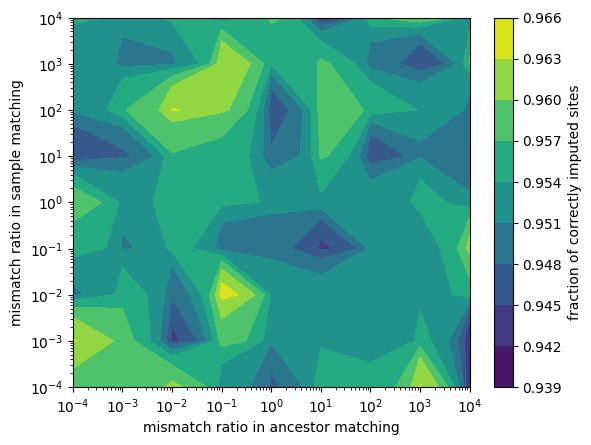

In [18]:
from matplotlib import pyplot as plt

z = np.zeros((len(mismatch_params), len(mismatch_params)))
mm2index = {v: i for i, v in enumerate(mismatch_params)}

for param, res in results.items():
    z[mm2index[param.mm_ancestors], mm2index[param.mm_samples]] += res[0]/res[1]

z = z / num_replicates

CS = plt.contourf(mismatch_params, mismatch_params, z)
plt.xscale('log')
plt.xlabel('mismatch ratio in ancestor matching')
plt.yscale('log')
plt.ylabel('mismatch ratio in sample matching')
cbar = plt.colorbar(CS)
cbar.ax.set_ylabel('fraction of correctly imputed sites')
plt.show()

In [16]:
results

{Params(mm_ancestors=0.0001, mm_samples=0.0001, replicate=0): (384, 400),
 Params(mm_ancestors=0.0001, mm_samples=0.0001, replicate=1): (386, 400),
 Params(mm_ancestors=0.0001, mm_samples=0.0001, replicate=2): (382, 400),
 Params(mm_ancestors=0.0001, mm_samples=0.0001, replicate=3): (383, 400),
 Params(mm_ancestors=0.0001, mm_samples=0.001, replicate=0): (379, 400),
 Params(mm_ancestors=0.0001, mm_samples=0.001, replicate=1): (379, 400),
 Params(mm_ancestors=0.0001, mm_samples=0.001, replicate=2): (384, 400),
 Params(mm_ancestors=0.0001, mm_samples=0.001, replicate=3): (392, 400),
 Params(mm_ancestors=0.0001, mm_samples=0.01, replicate=0): (382, 400),
 Params(mm_ancestors=0.0001, mm_samples=0.01, replicate=1): (388, 400),
 Params(mm_ancestors=0.0001, mm_samples=0.01, replicate=2): (385, 400),
 Params(mm_ancestors=0.0001, mm_samples=0.01, replicate=3): (382, 400),
 Params(mm_ancestors=0.0001, mm_samples=0.1, replicate=0): (378, 400),
 Params(mm_ancestors=0.0001, mm_samples=0.1, replicat